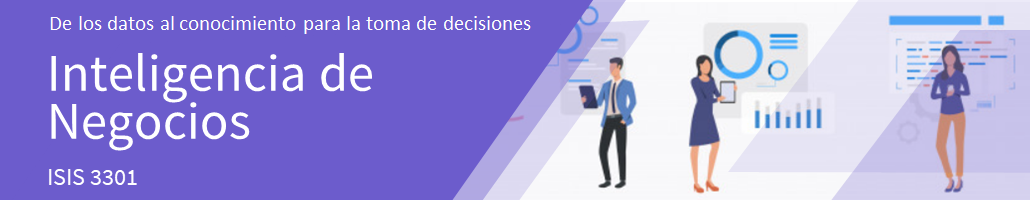

## Parcial 1 Etapa 1.
## Clasificación RandomForest

En este notebook se planteara el uso de un algoritmo de clasificación como es el randomForest con el fin de determinar la relación entre los factores de influencia asociados a los accidentes de tránsito y la gravedad de este a partir de datos históricos.

Para esto, se plantea usar este algoritmo de clasificación con el propósito de determinar la importancia que tiene cada variable en la gravedad de los accidentes de tránsito, para esto se deben preparar los datos numéricos, y en caso que se necesite, transformar datos clasificadores a numéricos.

Esta propuesta es apropiada debido a que este algoritmo permite clasificar en grupos aquellos datos que tengan datos característicos entre sí, basado en la importancia que tienen los factores que lo describen.

1. Importación de librerías.
2. Carga de los datos.
3. Limpieza y preparación de los datos.
4. Construcción del modelo.
5. Interpretación del modelo.
6. Predicciones y probabilidad.

### 1. Importación de librerías 

En las siguientes líneas de código se importan las librerías y herramientas necesarias para desarrollar el caso de uso.

In [1]:
# Librerías para manejo de datos
import pandas as pd
pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Numero máximo de filas a mostar
import numpy as np
np.random.seed(3301)
import pandas as pd
# Para preparar los datos
from sklearn.preprocessing import LabelEncoder
# Para crear el bosque 
from sklearn.ensemble import RandomForestClassifier
# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 
#Librerías para la visualización
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns 

### 2. Carga de los datos
A través de la librería pandas resalizamos la carga de datos del archivo "Accidentes.csv". el separador que se usará para la carga es ";".

In [2]:
# Se cargan los datos. 
df=pd.read_csv('Accidentes.csv', sep=';')

In [3]:
# Cantidad de datos y número de variables
df.shape

(2809, 12)

In [4]:
df.dtypes

ID                        object
Severidad_accidente       object
Numero_vehiculos           int64
Numero_victimas           object
Dia_semana                 int64
Tipo_via                  object
Limite_velocidad           int64
Iluminacion               object
Clima                     object
Condicion_via             object
Condiciones especiales    object
Tipo_area                 object
dtype: object

Como podemos ver hay datos que deberían ser numéricos, pero por alguna razón estos son tipo "object".

In [5]:
# Mostrar los datos
df.head()

,ID,Severidad_accidente,Numero_vehiculos,Numero_victimas,Dia_semana,Tipo_via,Limite_velocidad,Iluminacion,Clima,Condicion_via,Condiciones especiales,Tipo_area
0,201143N077061,Fatal,5,1,7,Autovia,70,Luz_dia,Bueno,Seca,No,Rural
1,200697LB70507,Fatal,1,1,2,Calzada,60,Luz_dia,Bueno,Seca,No,Rural
2,200897UA70101,Fatal,1,1,4,Calzada,30,Oscuridad con luces encendidas,Bueno,Humeda,No,Urbano
3,20114100D0277,Fatal,1,1,4,Calzada,40,Oscuridad sin iluminacion,Bueno,Seca,No,Rural
4,20141316C1381,Fatal,1,1,5,Calzada,40,Luz_dia,Bueno,Seca,No,Rural


Se corrige la columna de número victimas que no tiene tipo de dato correcto. Para esto se eliminan los outlier y se toman todos los datos como integer, es decir, cualquier dato float es transformado al entero más proximo.

In [6]:
df.loc[df['Numero_victimas'] == '70.000.000']
df.loc[df['Numero_victimas'] == '44444444']
df = df.drop(df.index[1565])
df = df.drop(df.index[107])
df['Numero_victimas'] = pd.to_numeric(df['Numero_victimas'], downcast="integer")
df['Numero_victimas']=df['Numero_victimas'].astype(int)
df.dtypes

ID                        object
Severidad_accidente       object
Numero_vehiculos           int64
Numero_victimas            int32
Dia_semana                 int64
Tipo_via                  object
Limite_velocidad           int64
Iluminacion               object
Clima                     object
Condicion_via             object
Condiciones especiales    object
Tipo_area                 object
dtype: object

### 3. Limpieza y preparación de los datos

Para la limpieza de datos, se revisa que no registros vacios o hayan duplicados. Luego para la preparación de datos, se decide transformar variables categóricas a numéricas para el modelo

In [7]:
# Se observa si hay ausencias
# También decidimos eliminar la columna ID ya que no nos sirve para el modelo
df_accidentes = df.copy()
df_accidentes.drop('ID', axis=1, inplace=True)
df_accidentes.isnull().sum()

Severidad_accidente        5
Numero_vehiculos           0
Numero_victimas            0
Dia_semana                 0
Tipo_via                  17
Limite_velocidad           0
Iluminacion                1
Clima                     15
Condicion_via              0
Condiciones especiales     0
Tipo_area                  1
dtype: int64

Como son pocas ausencias, decidimos eliminar todos los registros que las tengan.

In [8]:
df_accidentes = df_accidentes.dropna()
df_accidentes.shape

(2768, 11)

In [9]:
df_accidentes.duplicated(keep=False)

0       False
1        True
2       False
3        True
4       False
        ...  
2804    False
2805     True
2806     True
2807    False
2808    False
Length: 2768, dtype: bool

In [10]:
# Acá podemos ver las columnas con datos numéricos
df_accidentes.describe()

,Numero_vehiculos,Numero_victimas,Dia_semana,Limite_velocidad
count,2768.000000,2768.000000,2768.000000,2768.000000
mean,1.798049,1.379335,4.150650,44.423410
std,0.720426,0.845426,1.972908,208.474485
min,1.000000,1.000000,1.000000,-70.000000
25%,1.000000,1.000000,2.000000,30.000000
50%,2.000000,1.000000,4.000000,30.000000
75%,2.000000,1.250000,6.000000,50.000000
max,8.000000,13.000000,12.000000,7777.000000


Ahora podemos ver los datos que queremos transformar a numéricos, esto se debe a que Scikit-learn requiere que todos los atributos sean numéricos y que la variable objetivo, en una tarea de clasificación, esté codificada con números.

In [11]:
df_accidentes['Tipo_via'].value_counts()

Calzada             2078
Autovia              449
Rotonda              157
Un solo sentido       58
Carretera acceso      26
Name: Tipo_via, dtype: int64

In [12]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def definir_via (row):
    if row['Tipo_via'] == 'Calzada' :
        return 1
    elif row['Tipo_via'] == 'Autovia' :
        return 2
    elif row['Tipo_via'] == 'Rotonda' :
        return 3
    elif row['Tipo_via'] == 'Un solo sentido' :
        return 4
    return 5
df_accidentes['Tipo_Via']=df_accidentes.apply (lambda row: definir_via(row), axis=1)   
df_accidentes['Tipo_Via'].value_counts()

1    2078
2     449
3     157
4      58
5      26
Name: Tipo_Via, dtype: int64

In [13]:
df_accidentes['Iluminacion'].value_counts()

Luz_dia                           1966
Oscuridad con luces encendidas     607
Oscuridad sin iluminacion          162
0                                   20
Oscuridad con luces apagadas        13
Name: Iluminacion, dtype: int64

In [14]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def Iluminacion_via (row):
    if row['Iluminacion'] == 'Luz_dia' :
        return 1
    elif row['Iluminacion'] == 'Oscuridad con luces encendidas' :
        return 2
    elif row['Iluminacion'] == 'Oscuridad sin iluminacion' :
        return 3
    return 4
df_accidentes['Iluminacion_Via']=df_accidentes.apply (lambda row: Iluminacion_via(row), axis=1)   
df_accidentes['Iluminacion_Via'].value_counts()

1    1966
2     607
3     162
4      33
Name: Iluminacion_Via, dtype: int64

In [15]:
df_accidentes['Clima'].value_counts()

Bueno                 2246
Lluvioso               316
Ventoso                 81
Nieve y ventoso         54
Niebla                  45
Nieve                   21
LLuvioso y ventoso       5
Name: Clima, dtype: int64

In [16]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def tipo_clima (row):
    if row['Clima'] == 'Bueno' :
        return 1
    elif row['Clima'] == 'Lluvioso' :
        return 2
    elif row['Clima'] == 'Ventoso' :
        return 3
    elif row['Clima'] == 'Niebla' :
        return 3
    return 5
df_accidentes['tipo_clima']=df_accidentes.apply (lambda row: tipo_clima(row), axis=1)   
df_accidentes['tipo_clima'].value_counts()

1    2246
2     316
3     126
5      80
Name: tipo_clima, dtype: int64

In [17]:
df_accidentes['Condicion_via'].value_counts()

Seca         1884
Humeda        807
Hielo          57
Con nieve      18
Inundada        2
Name: Condicion_via, dtype: int64

In [18]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def definir_condicion (row):
    if row['Condicion_via'] == 'Seca' :
        return 1
    elif row['Condicion_via'] == 'Humeda' :
        return 2
    elif row['Condicion_via'] == 'Hielo' :
        return 3
    elif row['Condicion_via'] == 'Con nieve' :
        return 4
    return 5
df_accidentes['Condicion_Via']=df_accidentes.apply (lambda row: definir_condicion(row), axis=1)   
df_accidentes['Condicion_Via'].value_counts()

1    1884
2     807
3      57
4      18
5       2
Name: Condicion_Via, dtype: int64

In [19]:
df_accidentes['Condiciones especiales'].value_counts()

No    2710
Si      58
Name: Condiciones especiales, dtype: int64

In [20]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def definir_condicion_especial (row):
    if row['Condiciones especiales'] == 'Si' :
        return 1
    return 0
df_accidentes['Condicion_especial_Via']=df_accidentes.apply (lambda row: definir_condicion_especial(row), axis=1)   
df_accidentes['Condicion_especial_Via'].value_counts()

0    2710
1      58
Name: Condicion_especial_Via, dtype: int64

In [21]:
df_accidentes['Tipo_area'].value_counts()

Urbano    1859
Rural      909
Name: Tipo_area, dtype: int64

In [22]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def definir_tipo_area (row):
    if row['Tipo_area'] == 'Urbano' :
        return 1
    return 0
df_accidentes['Tipo_Area']=df_accidentes.apply (lambda row: definir_tipo_area(row), axis=1)   
df_accidentes['Tipo_Area'].value_counts()

1    1859
0     909
Name: Tipo_Area, dtype: int64

In [23]:
df_accidentes.head()

,Severidad_accidente,Numero_vehiculos,Numero_victimas,Dia_semana,Tipo_via,Limite_velocidad,Iluminacion,Clima,Condicion_via,Condiciones especiales,Tipo_area,Tipo_Via,Iluminacion_Via,tipo_clima,Condicion_Via,Condicion_especial_Via,Tipo_Area
0,Fatal,5,1,7,Autovia,70,Luz_dia,Bueno,Seca,No,Rural,2,1,1,1,0,0
1,Fatal,1,1,2,Calzada,60,Luz_dia,Bueno,Seca,No,Rural,1,1,1,1,0,0
2,Fatal,1,1,4,Calzada,30,Oscuridad con luces encendidas,Bueno,Humeda,No,Urbano,1,2,1,2,0,1
3,Fatal,1,1,4,Calzada,40,Oscuridad sin iluminacion,Bueno,Seca,No,Rural,1,3,1,1,0,0
4,Fatal,1,1,5,Calzada,40,Luz_dia,Bueno,Seca,No,Rural,1,1,1,1,0,0


In [24]:
# Eliminaremos las columnas que ya transformamos
df_accidentes_prep = df_accidentes.drop(['Tipo_via', 'Iluminacion', 'Clima', 'Condicion_via', 'Condiciones especiales', 'Tipo_area'], axis=1)
df_accidentes_prep.dtypes

Severidad_accidente       object
Numero_vehiculos           int64
Numero_victimas            int32
Dia_semana                 int64
Limite_velocidad           int64
Tipo_Via                   int64
Iluminacion_Via            int64
tipo_clima                 int64
Condicion_Via              int64
Condicion_especial_Via     int64
Tipo_Area                  int64
dtype: object

Ahora se prepara la variable objetivo

In [25]:
df_accidentes_prep['Severidad_accidente'].value_counts()

Leve     1868
Serio     610
Fatal     290
Name: Severidad_accidente, dtype: int64

In [26]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def definir_condicion (row):
    if row['Severidad_accidente'] == 'Leve' :
        return 1
    elif row['Severidad_accidente'] == 'Serio' :
        return 2
    return 3
df_accidentes_prep['Severidad']=df_accidentes_prep.apply (lambda row: definir_condicion(row), axis=1)
df_accidentes_prep.drop('Severidad_accidente', axis=1, inplace=True)
df_accidentes_prep['Severidad'].value_counts()

1    1868
2     610
3     290
Name: Severidad, dtype: int64

In [27]:
# Podemos ver como quedaron los datos
df_accidentes_prep.head()

,Numero_vehiculos,Numero_victimas,Dia_semana,Limite_velocidad,Tipo_Via,Iluminacion_Via,tipo_clima,Condicion_Via,Condicion_especial_Via,Tipo_Area,Severidad
0,5,1,7,70,2,1,1,1,0,0,3
1,1,1,2,60,1,1,1,1,0,0,3
2,1,1,4,30,1,2,1,2,0,1,3
3,1,1,4,40,1,3,1,1,0,0,3
4,1,1,5,40,1,1,1,1,0,0,3


In [28]:
# Revisión del total de registros
df_model = df_accidentes_prep.copy()
df_model.shape

(2768, 11)

### 4. Construcción del modelo

Los algoritmos supervisados implementados en scikit-learn requieren que las variables de entrada estén separadas de la variable objetivo. 

In [29]:
# Se selecciona la variable objetivo, en este caso "Severidad".
Y = df_model['Severidad']
# Del conjunto de datos se elimina la variable "Severidad"
X = df_model.drop(['Severidad'], axis=1)

In [30]:
# Dividir los datos en entrenamiento y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [31]:
# Crear el objeto bosque. Utilicemos como criterio de pureza la entropía.
bosque = RandomForestClassifier(criterion='entropy', random_state=0)

In [32]:
# Entrenar el modelo de bosque con los datos de entrenamiento
bosque = bosque.fit(X_train,Y_train)

Para determinar el rendimiento del modelo podemos en primer lugar, generar la matriz de confusión.

In [33]:
# Determinamos las predicciones del modelo sobre el conjunto test.
y_pred = bosque.predict(X_test)

In [34]:
# Se genera la matriz de confusión
confusion_matrix(Y_test, y_pred)

array([[326,  33,  14],
       [106,  11,  12],
       [ 31,  10,  11]], dtype=int64)

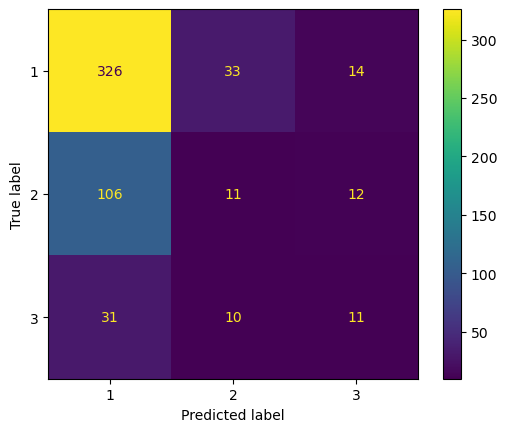

In [35]:
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(bosque, X_test, Y_test)  
plt.show()  

Para tener una panorama completo generamos un reporte.

In [36]:
# Mostrar reporte de clasificación
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           1       0.70      0.87      0.78       373
           2       0.20      0.09      0.12       129
           3       0.30      0.21      0.25        52

    accuracy                           0.63       554
   macro avg       0.40      0.39      0.38       554
weighted avg       0.55      0.63      0.58       554



Como podemos ver no tenemos una predicción exacta, por lo que no tenemos ninguna columna que se utilizó para calcular la variable objetivo, dentro de las variables de entrada

### 5. Interpretación del modelo.
Lo siguiente que haremos es la interpretación de cuáles son los atributos más importante a partir del modelo que generamos con mayor nivel de pureza. 

In [37]:
# Obtener la importancia de las variables. Para esto podemos utilizar uno de los atributos del modelo "feature_importances_", el
# cual nos devuelve un coeficiente o peso para cada atributo: mientras más grande sea este más importante será la variable
# asociada.
importancia= bosque.feature_importances_
importancia

array([0.12850763, 0.11390342, 0.26692008, 0.1206674 , 0.07991931,
       0.07806727, 0.07765907, 0.07884461, 0.01496465, 0.04054655])

In [38]:
importancia_atributo = pd.DataFrame(data={"Atributo": X_train.columns,"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo

,Atributo,Importancia
0,Dia_semana,0.266920
1,Numero_vehiculos,0.128508
2,Limite_velocidad,0.120667
3,Numero_victimas,0.113903
4,Tipo_Via,0.079919
5,Condicion_Via,0.078845
6,Iluminacion_Via,0.078067
7,tipo_clima,0.077659
8,Tipo_Area,0.040547
9,Condicion_especial_Via,0.014965


Como podemos ver, el atributo con más importancia es el día de la semana. Esto puede tener sentido debido a la cantidad de carros que se encuentran en la via dependiendo del día que se encuentre.

### 6. Predicciones y probabilidad

Una vez obtenido el modelo de árbol de decisión vamos a obtener la probabilidad de que un dato sea clasificado como de una clase particular segun la severidad

In [39]:
#tomamos un dato del conjunto de test y aplicamos el método "predict_proba".
y_pred_test = bosque.predict_proba(X_test.iloc[[105]])

In [40]:
print(y_pred_test)

[[0.73077201 0.26922799 0.        ]]


In [41]:
# Para saber el orden de las clases utilizamos el atributo "classes_" del modelo:
bosque.classes_

array([1, 2, 3], dtype=int64)

Como podemos observar cuando creamos la variable clase, el conjunto de datos está balanceado.

Gracias a este, podemos determinar la importancia que tiene cada característica dentro del tipo de accidente, es decir, su severidad.